# U-net - Example application

*Marcos R. A. Conceição*

## U-net architechure

A U-net is a state-of-art fully convolutional neural network (FCNN) first described by Ronneberger *et al.* (2015). Such network is based on three major pillars: encoder-decoder structure, multi-scale analysis and skip-connections. A typical U-net gets high-resolution $N$-dimensional tensor data as input (i.e., time series, images and volumes), which suffers multiple filtering by a number of trainable convolutional kernels, applied to an activation function and reduced on its dimensions for a posterior lower resolution processing. This sequence is applied, scale after scale, down to the last one. Such process is called the encoding, as the lower resolution layers hold condensed representations of abstract features present in the original data. Such condition is forced during trained, once such low resolution representations need to be decompressed by the network on later decoding steps. Each of such steps resizes inputs to the resolution used on the upper scale and performs other number of similar filtering operations. A key improvement used in U-nets are the so called skip connections. At each scale, before filtering the decompressed data, they are concatenated with the last outputs gotten for the same scale, back in the compression stage. This simple addition gets previously available higher resolution data features to be recalled by the network, making U-net results remarkably precise when locating events, when compared to other networks (even when it comes to common FCNNs). The last step in this model is the application of $M$ convolutional filters to the outputs --- now in the original scale --- which are going to produce $M$ outputs on each data dimension. These outputs may represent probability of belonging to each of the $M$ considered classes when segmentation is the task, or even the $M$ different channels of output image.

## Example problem

Here we will use a U-net over mnist dataset to perform segmentation of zeros on input image.

## Importing libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks

import sklearn.datasets as skds
from sklearn.model_selection import train_test_split

from unet import make_unet
from tfg_modified import trilinear_interpolate, trilinear_resample

## Setting up the data

In [3]:
X, y = skds.load_digits(n_class=10, return_X_y=True)
X = X.reshape(-1, 8, 8, 1)

In [4]:
X_mean = X.mean(axis=(1,2,3))[:,None,None,None]
X_std = X.std(axis=(1,2,3))[:,None,None,None]
X_norm = (X-X_mean)/X_std
thresh = .5
Y = X_norm >= thresh

In [5]:
num_masked = 0
Y_num = Y * (y==num_masked)[:, None, None, None]
del(X_mean)
del(X_std)
del(X_norm)

In [6]:
X_true = X
Y_true = Y_num

## Balancing dataset

In [7]:
idx_masked, = np.nonzero(y==num_masked)
idx_not_masked, = np.nonzero(y!=num_masked)

idx_masked.size / y.size

0.09905397885364496

In [8]:
idx_balance = np.concatenate([idx_masked, idx_not_masked[:idx_masked.size]])
np.random.shuffle(idx_balance)

X_true = X_true[idx_balance]
Y_true = Y_true[idx_balance]

## Showing data

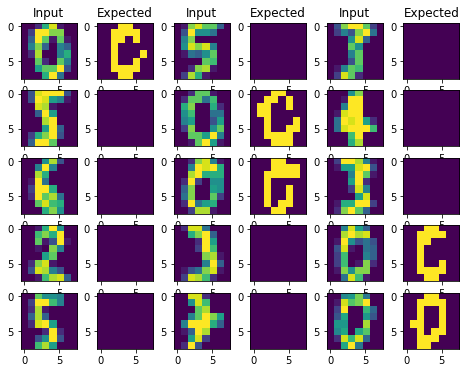

In [9]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 2*ncols, figsize=(8, 6))
for j in range(0, axes.shape[1], 2):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

## Defining U-net

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
# import tensorflow_graphics.math.interpolation as tfgmi
# import tensorflow.keras as keras
import keras as K
import numpy as np
from os import environ

In [561]:
def make_unet(input_shape,
              batch_size=None,
              nout=1,
              scales=5,
              nconvs_by_scale=2,
              base_filters=8,
              kernel_size=3,
              activation='relu',
              first_activation='tanh',
              last_activation='linear',
              interpolator='nearest',
              last_interpolator=None,
              norm=False,
              dropout=False,
              norm_at_start=False,
              nconvs_bottom=None,
              use_skip_connections=True,
              return_encoders=False,
              verbose=False):
    '''
    Makes 1D or 2D U-net model with resising instead of upsampling layers when
    decoding.
    '''
    # TODO add dropout?

    *resolution, feats = input_shape
    ndim = len(resolution)

    if ndim == 1:
        Conv = layers.Conv1D
        Pooling = layers.AveragePooling1D
        SpatialDropout = layers.SpatialDropout1D
    elif ndim == 2:
        Conv = layers.Conv2D
        Pooling = layers.AveragePooling2D
        SpatialDropout = layers.SpatialDropout2D
    elif ndim == 3:
        Conv = layers.Conv3D
        Pooling = layers.AveragePooling3D
        SpatialDropout = layers.SpatialDropout3D
    else:
        raise IndexError('Input data must be 1D or 2D.')

    nconvs_bottom = nconvs_bottom or nconvs_by_scale
    first_activation = first_activation or activation
    last_activation = last_activation or activation
    last_interpolator = last_interpolator or interpolator
    
    def nearest_resample_3d(tensor, shape):
        idx = tf.cast(tf.where(tf.ones(shape[1:-1], dtype=tf.uint8)), dtype=tf.float32)
        idx *= (tf.cast(tensor.shape[1:-1], dtype=tf.float32) - 1) / (tf.cast(shape[1:-1], tf.float32) - 1)
        idx = tf.cast(tf.round(tf.where(~tf.math.is_nan(idx), idx, 0)), dtype=tf.int64)
        idx = tf.repeat(idx[None, ...], shape[0], axis=0)
        interp = tf.gather_nd(tensor, idx, batch_dims=1)
        return tf.reshape(interp, shape)
    
    def ConvLayer(x,
                  filters,
                  kernel_size=kernel_size,
                  strides=1,
                  activation=activation):
        '''Default convolution layer + activation operation.'''
        x = Conv(filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding='same')(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        return x

    def encode(x):
        '''Defines U-net encoding phase.'''
        if verbose:
            print('start   ', x.shape)

        if norm_at_start:
            x = layers.BatchNormalization()(x)

        x = ConvLayer(x, base_filters, activation=first_activation)

        if verbose:
            print('prepare ', x.shape)

        old = []

        # downward path
        for scale in range(scales):
            filters = base_filters * 2**(scale + 1)
            for conv in range(nconvs_by_scale):
                x = ConvLayer(x, filters, activation=activation)
            if norm:
                x = layers.BatchNormalization()(x)

            # saving convolution output for skip connections
            old.append(x)

            # lowering resolution
            x = Pooling(pool_size=3, strides=2, padding='same')(x)
            if verbose:
                print('downward', x.shape)

        # bottom path
        for conv in range(nconvs_bottom):
            x = ConvLayer(x, filters)
        if dropout:
            x = SpatialDropout(dropout)(x)
        if norm:
            x = layers.BatchNormalization()(x)

        return x, old

    def decode(x, old):
        '''Defines U-net decoding phase.'''
        # upward path
        for scale in range(scales - 1, -1, -1):
            x_old = old[scale]
            filters = int(x_old.shape[-1] / 2)

            # 3D upsample
            x_old_exp = x_old
            for d_miss in range(3 - ndim):
                x = tf.expand_dims(x, axis=3)
                x_old_exp = tf.expand_dims(x_old_exp, axis=3)
            x = nearest_resample_3d(x, tf.shape(x_old_exp))
#             x = nearest_resample_3d(x, x_old_exp.shape)
            for d_miss in range(3 - ndim):
                x = tf.squeeze(x, axis=3+d_miss)

            if use_skip_connections:
                x = layers.Concatenate()([x_old, x])

            for conv in range(nconvs_by_scale):
                x = ConvLayer(x, filters)
            if norm:
                x = layers.BatchNormalization()(x)
            if verbose:
                print('upward  ', x.shape)

        # final convolution return correct number of outputs
        x = ConvLayer(x, nout, activation=last_activation)

        if verbose:
            print('out     ', x.shape)

        return x

    encoder_input = K.Input(shape=input_shape, batch_size=batch_size, name='input_image')
    encoder_output, old = encode(encoder_input)
    decoder_output = decode(encoder_output, old)

    model = K.Model(encoder_input, decoder_output, name='unet')

    if return_encoders:
        old.append(encoder_output)
        encoders = [
            K.Model(encoder_input, encoder_output, name=f'encoder_{scale}')
            for scale, encoder_output in enumerate(old)
        ]
        return model, encoders
    return model

In [562]:
model = make_unet(
    X.shape[1:],
    nout=1,
    scales=2,
    nconvs_by_scale=2,
    base_filters=3,
    kernel_size=3,
    activation='relu',
    first_activation='tanh',
    last_activation='sigmoid',
    interpolator='bilinear',
    last_interpolator=None,
    norm=True,
    dropout=False,
    norm_at_start=True,
    nconvs_bottom=None,
    use_skip_connections=True,
    return_encoders=False,
    verbose=True,
)

start    (None, 8, 8, 1)
prepare  (None, 8, 8, 3)
downward (None, 4, 4, 6)
downward (None, 2, 2, 12)
upward   (None, 4, 4, 6)
upward   (None, 8, 8, 3)
out      (None, 8, 8, 1)


## U-net predictions - before training

57/57 [==============================] - 1s 23ms/step


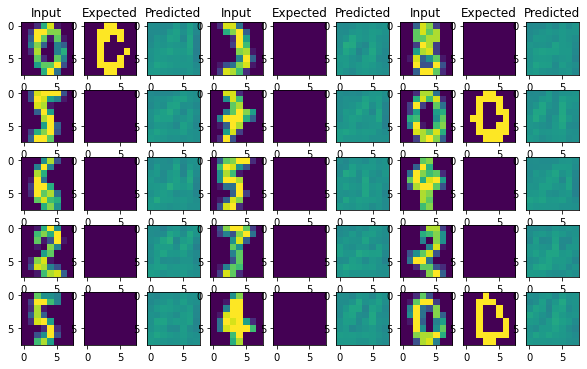

In [563]:
Y_pred_proba = model.predict(X)

i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred_proba[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

## Preparing holdout validation

In [564]:
X_train, X_test, Y_train, Y_test = train_test_split(X_true,
                                                    Y_true,
                                                    test_size=1 / 4)
print('n_train: {X_train.shape[0]}')
print('n_test:  {X_test.shape[0]}\n')

n_train: {X_train.shape[0]}
n_test:  {X_test.shape[0]}



## Training U-net

In [ ]:
learning_rate = 0.0005
max_epochs = 2000
batch_size = X_train.shape[0]
# batch_size = 100

optim = optimizers.Adam(learning_rate)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

callback_list = [
    callbacks.EarlyStopping(
        mode='min',
        monitor='val_loss',
        patience=80,
        min_delta=0,
        verbose=1,
        baseline=None,
        restore_best_weights=True,
    )
]

train = model.fit(X_train,
                  Y_train,
                  epochs=max_epochs,
                  validation_data=(X_test, Y_test),
                  callbacks=callback_list,
                  batch_size=batch_size)

Epoch 1/2000
1/1 [==============================] - 0s 196ms/step - loss: 0.8109 - accuracy: 0.5831 - val_loss: 0.7100 - val_accuracy: 0.4350
Epoch 2/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.7833 - accuracy: 0.5940 - val_loss: 0.7078 - val_accuracy: 0.4500
Epoch 3/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.7581 - accuracy: 0.6045 - val_loss: 0.7056 - val_accuracy: 0.4608
Epoch 4/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.7354 - accuracy: 0.6155 - val_loss: 0.7035 - val_accuracy: 0.4717
Epoch 5/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.7148 - accuracy: 0.6265 - val_loss: 0.7013 - val_accuracy: 0.4828
Epoch 6/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.6965 - accuracy: 0.6359 - val_loss: 0.6992 - val_accuracy: 0.4970
Epoch 7/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.6803 - accuracy: 0.6444 - val_loss: 0.6972 - val_accuracy: 0.5056
Epoch 

1/1 [==============================] - 0s 122ms/step - loss: 0.4296 - accuracy: 0.8600 - val_loss: 0.6124 - val_accuracy: 0.8316
Epoch 59/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.4273 - accuracy: 0.8625 - val_loss: 0.6107 - val_accuracy: 0.8330
Epoch 60/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.4250 - accuracy: 0.8651 - val_loss: 0.6089 - val_accuracy: 0.8357
Epoch 61/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.4227 - accuracy: 0.8679 - val_loss: 0.6072 - val_accuracy: 0.8376
Epoch 62/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.4204 - accuracy: 0.8700 - val_loss: 0.6054 - val_accuracy: 0.8394
Epoch 63/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.4182 - accuracy: 0.8716 - val_loss: 0.6037 - val_accuracy: 0.8401
Epoch 64/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.4159 - accuracy: 0.8735 - val_loss: 0.6019 - val_accuracy: 0.8420
Epoch 65/2000

1/1 [==============================] - 0s 123ms/step - loss: 0.3298 - accuracy: 0.9404 - val_loss: 0.5108 - val_accuracy: 0.8634
Epoch 116/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.3285 - accuracy: 0.9405 - val_loss: 0.5091 - val_accuracy: 0.8639
Epoch 117/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.3271 - accuracy: 0.9414 - val_loss: 0.5074 - val_accuracy: 0.8641
Epoch 118/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.3258 - accuracy: 0.9419 - val_loss: 0.5058 - val_accuracy: 0.8639
Epoch 119/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.3245 - accuracy: 0.9424 - val_loss: 0.5041 - val_accuracy: 0.8641
Epoch 120/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.3232 - accuracy: 0.9430 - val_loss: 0.5025 - val_accuracy: 0.8638
Epoch 121/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.3219 - accuracy: 0.9439 - val_loss: 0.5008 - val_accuracy: 0.8638
Epoch 1

Epoch 172/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.2622 - accuracy: 0.9596 - val_loss: 0.4237 - val_accuracy: 0.8632
Epoch 173/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.2611 - accuracy: 0.9600 - val_loss: 0.4224 - val_accuracy: 0.8639
Epoch 174/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.2600 - accuracy: 0.9601 - val_loss: 0.4211 - val_accuracy: 0.8641
Epoch 175/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.2589 - accuracy: 0.9601 - val_loss: 0.4197 - val_accuracy: 0.8643
Epoch 176/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.2578 - accuracy: 0.9603 - val_loss: 0.4184 - val_accuracy: 0.8643
Epoch 177/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.2567 - accuracy: 0.9603 - val_loss: 0.4171 - val_accuracy: 0.8648
Epoch 178/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.2556 - accuracy: 0.9607 - val_loss: 0.4158 - val_accuracy:

Epoch 229/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.2061 - accuracy: 0.9697 - val_loss: 0.3620 - val_accuracy: 0.8775
Epoch 230/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.2052 - accuracy: 0.9699 - val_loss: 0.3611 - val_accuracy: 0.8773
Epoch 231/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.2043 - accuracy: 0.9700 - val_loss: 0.3602 - val_accuracy: 0.8776
Epoch 232/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.2034 - accuracy: 0.9703 - val_loss: 0.3594 - val_accuracy: 0.8775
Epoch 233/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.2025 - accuracy: 0.9706 - val_loss: 0.3585 - val_accuracy: 0.8773
Epoch 234/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.2016 - accuracy: 0.9708 - val_loss: 0.3576 - val_accuracy: 0.8776
Epoch 235/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.2007 - accuracy: 0.9710 - val_loss: 0.3567 - val_accuracy:

Epoch 286/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.1609 - accuracy: 0.9772 - val_loss: 0.3149 - val_accuracy: 0.8822
Epoch 287/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.1603 - accuracy: 0.9774 - val_loss: 0.3142 - val_accuracy: 0.8822
Epoch 288/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.1596 - accuracy: 0.9774 - val_loss: 0.3135 - val_accuracy: 0.8822
Epoch 289/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.1590 - accuracy: 0.9775 - val_loss: 0.3128 - val_accuracy: 0.8827
Epoch 290/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.1583 - accuracy: 0.9777 - val_loss: 0.3121 - val_accuracy: 0.8829
Epoch 291/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.1577 - accuracy: 0.9778 - val_loss: 0.3115 - val_accuracy: 0.8831
Epoch 292/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.1571 - accuracy: 0.9779 - val_loss: 0.3108 - val_accuracy:

Epoch 343/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.1287 - accuracy: 0.9820 - val_loss: 0.2724 - val_accuracy: 0.8917
Epoch 344/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.1282 - accuracy: 0.9821 - val_loss: 0.2715 - val_accuracy: 0.8920
Epoch 345/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.1277 - accuracy: 0.9819 - val_loss: 0.2707 - val_accuracy: 0.8924
Epoch 346/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.1273 - accuracy: 0.9820 - val_loss: 0.2700 - val_accuracy: 0.8922
Epoch 347/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.1268 - accuracy: 0.9826 - val_loss: 0.2692 - val_accuracy: 0.8926
Epoch 348/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.1263 - accuracy: 0.9827 - val_loss: 0.2683 - val_accuracy: 0.8927
Epoch 349/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.1258 - accuracy: 0.9824 - val_loss: 0.2675 - val_accuracy:

Epoch 400/2000
1/1 [==============================] - 0s 132ms/step - loss: 0.1039 - accuracy: 0.9877 - val_loss: 0.2221 - val_accuracy: 0.9138
Epoch 401/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.1035 - accuracy: 0.9872 - val_loss: 0.2215 - val_accuracy: 0.9143
Epoch 402/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.1032 - accuracy: 0.9880 - val_loss: 0.2203 - val_accuracy: 0.9142
Epoch 403/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.1028 - accuracy: 0.9872 - val_loss: 0.2196 - val_accuracy: 0.9145
Epoch 404/2000
1/1 [==============================] - 0s 137ms/step - loss: 0.1024 - accuracy: 0.9875 - val_loss: 0.2188 - val_accuracy: 0.9145
Epoch 405/2000
1/1 [==============================] - 0s 138ms/step - loss: 0.1020 - accuracy: 0.9879 - val_loss: 0.2179 - val_accuracy: 0.9150
Epoch 406/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.1016 - accuracy: 0.9874 - val_loss: 0.2175 - val_accuracy:

Epoch 457/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0844 - accuracy: 0.9905 - val_loss: 0.1803 - val_accuracy: 0.9336
Epoch 458/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0841 - accuracy: 0.9905 - val_loss: 0.1796 - val_accuracy: 0.9340
Epoch 459/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0838 - accuracy: 0.9905 - val_loss: 0.1790 - val_accuracy: 0.9342
Epoch 460/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0835 - accuracy: 0.9905 - val_loss: 0.1792 - val_accuracy: 0.9338
Epoch 461/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0833 - accuracy: 0.9905 - val_loss: 0.1777 - val_accuracy: 0.9352
Epoch 462/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0829 - accuracy: 0.9906 - val_loss: 0.1774 - val_accuracy: 0.9352
Epoch 463/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0826 - accuracy: 0.9906 - val_loss: 0.1775 - val_accuracy:

Epoch 514/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0691 - accuracy: 0.9932 - val_loss: 0.1527 - val_accuracy: 0.9479
Epoch 515/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0689 - accuracy: 0.9936 - val_loss: 0.1521 - val_accuracy: 0.9480
Epoch 516/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.0686 - accuracy: 0.9935 - val_loss: 0.1517 - val_accuracy: 0.9480
Epoch 517/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0684 - accuracy: 0.9935 - val_loss: 0.1513 - val_accuracy: 0.9480
Epoch 518/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0682 - accuracy: 0.9934 - val_loss: 0.1511 - val_accuracy: 0.9489
Epoch 519/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.0679 - accuracy: 0.9936 - val_loss: 0.1505 - val_accuracy: 0.9489
Epoch 520/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0677 - accuracy: 0.9936 - val_loss: 0.1508 - val_accuracy:

Epoch 571/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0567 - accuracy: 0.9958 - val_loss: 0.1308 - val_accuracy: 0.9570
Epoch 572/2000
1/1 [==============================] - 0s 118ms/step - loss: 0.0565 - accuracy: 0.9956 - val_loss: 0.1315 - val_accuracy: 0.9563
Epoch 573/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0563 - accuracy: 0.9961 - val_loss: 0.1298 - val_accuracy: 0.9575
Epoch 574/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0561 - accuracy: 0.9956 - val_loss: 0.1296 - val_accuracy: 0.9573
Epoch 575/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0559 - accuracy: 0.9958 - val_loss: 0.1292 - val_accuracy: 0.9579
Epoch 576/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0558 - accuracy: 0.9954 - val_loss: 0.1291 - val_accuracy: 0.9572
Epoch 577/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0556 - accuracy: 0.9960 - val_loss: 0.1287 - val_accuracy:

Epoch 628/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0468 - accuracy: 0.9971 - val_loss: 0.1136 - val_accuracy: 0.9633
Epoch 629/2000
1/1 [==============================] - 0s 130ms/step - loss: 0.0467 - accuracy: 0.9966 - val_loss: 0.1142 - val_accuracy: 0.9631
Epoch 630/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0466 - accuracy: 0.9971 - val_loss: 0.1134 - val_accuracy: 0.9633
Epoch 631/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0464 - accuracy: 0.9968 - val_loss: 0.1129 - val_accuracy: 0.9645
Epoch 632/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0462 - accuracy: 0.9969 - val_loss: 0.1133 - val_accuracy: 0.9638
Epoch 633/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0461 - accuracy: 0.9971 - val_loss: 0.1120 - val_accuracy: 0.9651
Epoch 634/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0460 - accuracy: 0.9968 - val_loss: 0.1130 - val_accuracy:

Epoch 685/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0391 - accuracy: 0.9980 - val_loss: 0.1058 - val_accuracy: 0.9668
Epoch 686/2000
1/1 [==============================] - 0s 132ms/step - loss: 0.0390 - accuracy: 0.9981 - val_loss: 0.1047 - val_accuracy: 0.9666
Epoch 687/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0389 - accuracy: 0.9978 - val_loss: 0.1047 - val_accuracy: 0.9675
Epoch 688/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0388 - accuracy: 0.9981 - val_loss: 0.1051 - val_accuracy: 0.9672
Epoch 689/2000
1/1 [==============================] - 0s 128ms/step - loss: 0.0387 - accuracy: 0.9977 - val_loss: 0.1041 - val_accuracy: 0.9670
Epoch 690/2000
1/1 [==============================] - 0s 124ms/step - loss: 0.0387 - accuracy: 0.9980 - val_loss: 0.1050 - val_accuracy: 0.9673
Epoch 691/2000
1/1 [==============================] - 0s 139ms/step - loss: 0.0384 - accuracy: 0.9978 - val_loss: 0.1044 - val_accuracy:

Epoch 742/2000
1/1 [==============================] - 0s 126ms/step - loss: 0.0331 - accuracy: 0.9986 - val_loss: 0.0997 - val_accuracy: 0.9679
Epoch 743/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0330 - accuracy: 0.9988 - val_loss: 0.1003 - val_accuracy: 0.9672
Epoch 744/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0329 - accuracy: 0.9987 - val_loss: 0.0998 - val_accuracy: 0.9684
Epoch 745/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0328 - accuracy: 0.9987 - val_loss: 0.0998 - val_accuracy: 0.9675
Epoch 746/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.0327 - accuracy: 0.9988 - val_loss: 0.1002 - val_accuracy: 0.9680
Epoch 747/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.0326 - accuracy: 0.9988 - val_loss: 0.0993 - val_accuracy: 0.9679
Epoch 748/2000
1/1 [==============================] - 0s 121ms/step - loss: 0.0326 - accuracy: 0.9988 - val_loss: 0.1002 - val_accuracy:

Epoch 799/2000
1/1 [==============================] - 0s 120ms/step - loss: 0.0283 - accuracy: 0.9991 - val_loss: 0.0994 - val_accuracy: 0.9673
Epoch 800/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0282 - accuracy: 0.9991 - val_loss: 0.0992 - val_accuracy: 0.9677
Epoch 801/2000
1/1 [==============================] - 0s 125ms/step - loss: 0.0281 - accuracy: 0.9991 - val_loss: 0.0990 - val_accuracy: 0.9679
Epoch 802/2000
1/1 [==============================] - 0s 123ms/step - loss: 0.0280 - accuracy: 0.9992 - val_loss: 0.0992 - val_accuracy: 0.9673
Epoch 803/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0280 - accuracy: 0.9991 - val_loss: 0.0987 - val_accuracy: 0.9684
Epoch 804/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0279 - accuracy: 0.9992 - val_loss: 0.0993 - val_accuracy: 0.9675
Epoch 805/2000
1/1 [==============================] - 0s 122ms/step - loss: 0.0278 - accuracy: 0.9991 - val_loss: 0.0993 - val_accuracy:

## Showing history

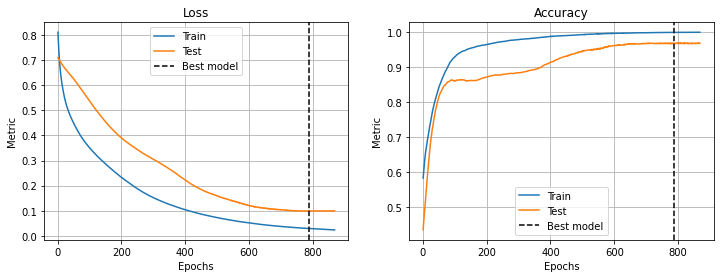

In [570]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = 1 + np.arange(len(train.history['loss']))

axes[0].set_title('Loss')
axes[0].plot(epochs, train.history['loss'], label='Train')
axes[0].plot(epochs, train.history['val_loss'], label='Test')
# axes[0].set_yscale('log')

axes[1].set_title('Accuracy')
axes[1].plot(epochs, train.history['accuracy'], label='Train')
axes[1].plot(epochs, train.history['val_accuracy'], label='Test')

for ax in axes:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metric')
    ax.grid()
    ax.axvline(
        epochs[np.argmin(train.history['val_loss'])],
        label='Best model',
        c='k',
        ls='--',
    )
    ax.legend()
plt.show()

## U-net predictions - after training

In [571]:
Y_pred_proba = model.predict(X_true)
Y_pred = Y_pred_proba >= .5

12/12 [==============================] - 0s 24ms/step


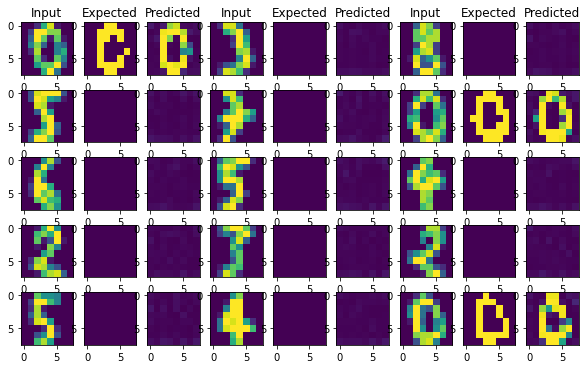

In [572]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred_proba[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()

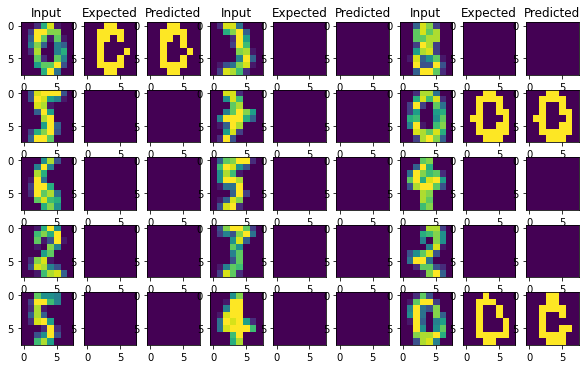

In [573]:
i0 = 1
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows, 3*ncols, figsize=(10, 6))
for j in range(0, axes.shape[1], 3):
    axes[0, j+0].set_title('Input')
    axes[0, j+1].set_title('Expected')
    axes[0, j+2].set_title('Predicted')
    for i in range(axes.shape[0]):
        axes[i, j+0].imshow(X_true[ncols*j+i0+i, ..., 0])
        axes[i, j+1].imshow(Y_true[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
        axes[i, j+2].imshow(Y_pred[ncols*j+i0+i, ..., 0], vmin=0, vmax=1)
plt.show()